


1/1 [==============================] - 0s 265ms/step


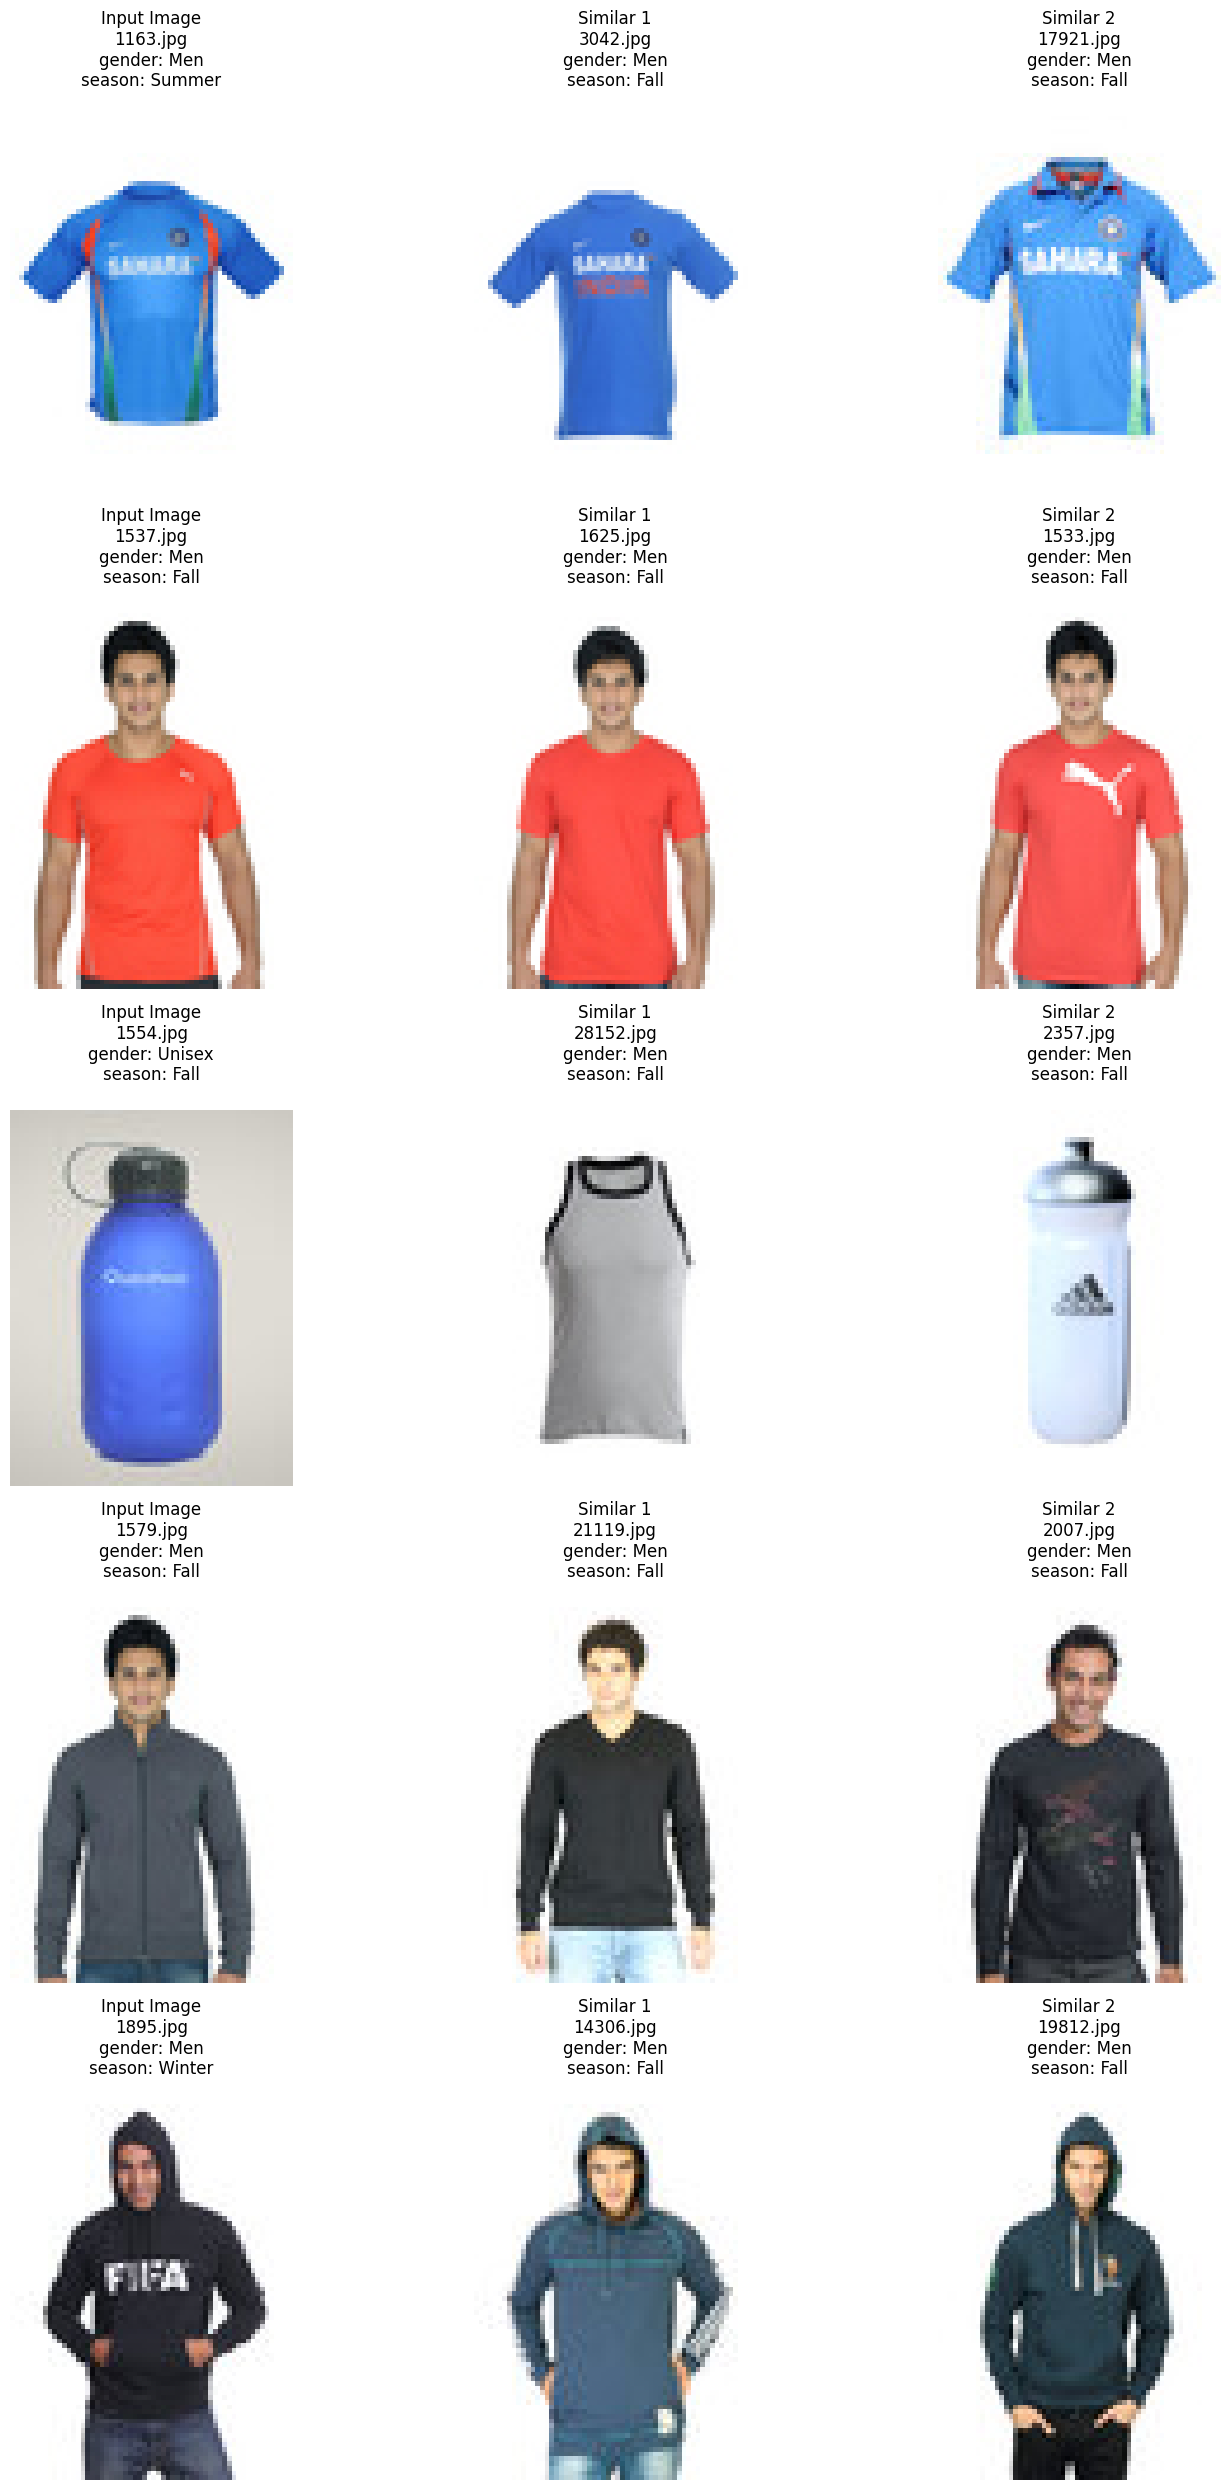

In [1]:
import os
import numpy as np
from numpy.linalg import norm
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalMaxPool2D
from tensorflow.keras.preprocessing import image
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import pickle as pkl
from PIL import Image
import matplotlib.pyplot as plt

# Charger les données
Image_features = pkl.load(open('Images_features.pkl', 'rb'))
filenames = pkl.load(open('filenames.pkl', 'rb'))
metadata = pd.read_csv('../dataset/styles.csv', on_bad_lines='skip')

# Convertir Image_features en array numpy
Image_features = np.array(Image_features)

# Préférences utilisateur
preferences = {
    'gender': 'Men',
    'season': 'Fall',
}

def get_id_from_filename(filename):
    """Extraire l'ID du nom de fichier (ex: '1163.jpg' -> '1163')"""
    return os.path.splitext(os.path.basename(filename))[0]

def extract_features_from_images(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_expand_dim = np.expand_dims(img_array, axis=0)
    img_preprocess = preprocess_input(img_expand_dim)
    result = model.predict(img_preprocess).flatten()
    norm_result = result / norm(result)
    return norm_result

# Charger le modèle ResNet50
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False
model = tf.keras.models.Sequential([model, GlobalMaxPool2D()])

# Initialiser Nearest Neighbors
neighbors = NearestNeighbors(n_neighbors=100, algorithm='brute', metric='euclidean')
neighbors.fit(Image_features)

# Dossier d'images d'entrée
input_image_folder = "../dataset/purchase_history"

if os.path.exists(input_image_folder) and os.path.isdir(input_image_folder):
    input_image_paths = [os.path.join(input_image_folder, file) 
                        for file in os.listdir(input_image_folder) 
                        if file.endswith(('.jpg', '.png', '.jpeg'))]
    
    if not input_image_paths:
        print("Aucune image trouvée dans le dossier.")
    else:
        fig, axes = plt.subplots(len(input_image_paths), 3, figsize=(15, 5*len(input_image_paths)))
        if len(input_image_paths) == 1:
            axes = [axes]

        for i, img_path in enumerate(input_image_paths):
            try:
                # Extraire les caractéristiques de l'image d'entrée
                feature = extract_features_from_images(img_path, model)
                
                # Trouver les images similaires
                distances, indices = neighbors.kneighbors([feature])
                
                # Filtrer les résultats selon les préférences
                similar_images = []
                
                for idx in indices[0]:
                    # Obtenir l'ID du fichier similaire
                    similar_file_id = get_id_from_filename(filenames[idx])
                    
                    # Trouver la correspondance dans metadata
                    meta_row = metadata[metadata['id'].astype(str) == similar_file_id]
                    
                    if not meta_row.empty:
                        row = meta_row.iloc[0]
                        # Vérifier les préférences
                        matches_preferences = all(
                            row[key] == value 
                            for key, value in preferences.items() 
                            if key in row
                        )
                        
                        if matches_preferences:
                            input_id = get_id_from_filename(img_path)
                            if similar_file_id != input_id:
                                similar_images.append(filenames[idx])
                                if len(similar_images) == 2:
                                    break

                # Affichage
                input_img = Image.open(img_path)
                axes[i][0].imshow(input_img)
                axes[i][0].axis('off')
                input_id = get_id_from_filename(img_path)
                input_meta = metadata[metadata['id'].astype(str) == input_id]
                if not input_meta.empty:
                    title = f"Input Image\n{os.path.basename(img_path)}\n"
                    for key in preferences.keys():
                        title += f"{key}: {input_meta.iloc[0][key]}\n"
                    axes[i][0].set_title(title)
                else:
                    axes[i][0].set_title(f"Input Image\n{os.path.basename(img_path)}")

                # Images similaires
                for j, similar_path in enumerate(similar_images):
                    if j < 2:
                        similar_img = Image.open(similar_path)
                        axes[i][j+1].imshow(similar_img)
                        axes[i][j+1].axis('off')
                        
                        similar_id = get_id_from_filename(similar_path)
                        similar_meta = metadata[metadata['id'].astype(str) == similar_id]
                        
                        if not similar_meta.empty:
                            title = f"Similar {j+1}\n{os.path.basename(similar_path)}\n"
                            for key in preferences.keys():
                                title += f"{key}: {similar_meta.iloc[0][key]}\n"
                            axes[i][j+1].set_title(title)
                        else:
                            axes[i][j+1].set_title(f"Similar {j+1}\n{os.path.basename(similar_path)}")
                    else:
                        axes[i][j+1].axis('off')
                        
            except Exception as e:
                print(f"Erreur lors du traitement de l'image {img_path}: {str(e)}")
                continue

        plt.tight_layout()
        plt.show()
else:
    print("Le dossier spécifié n'existe pas ou n'est pas valide.")

1/1 [==============================] - 0s 243ms/step


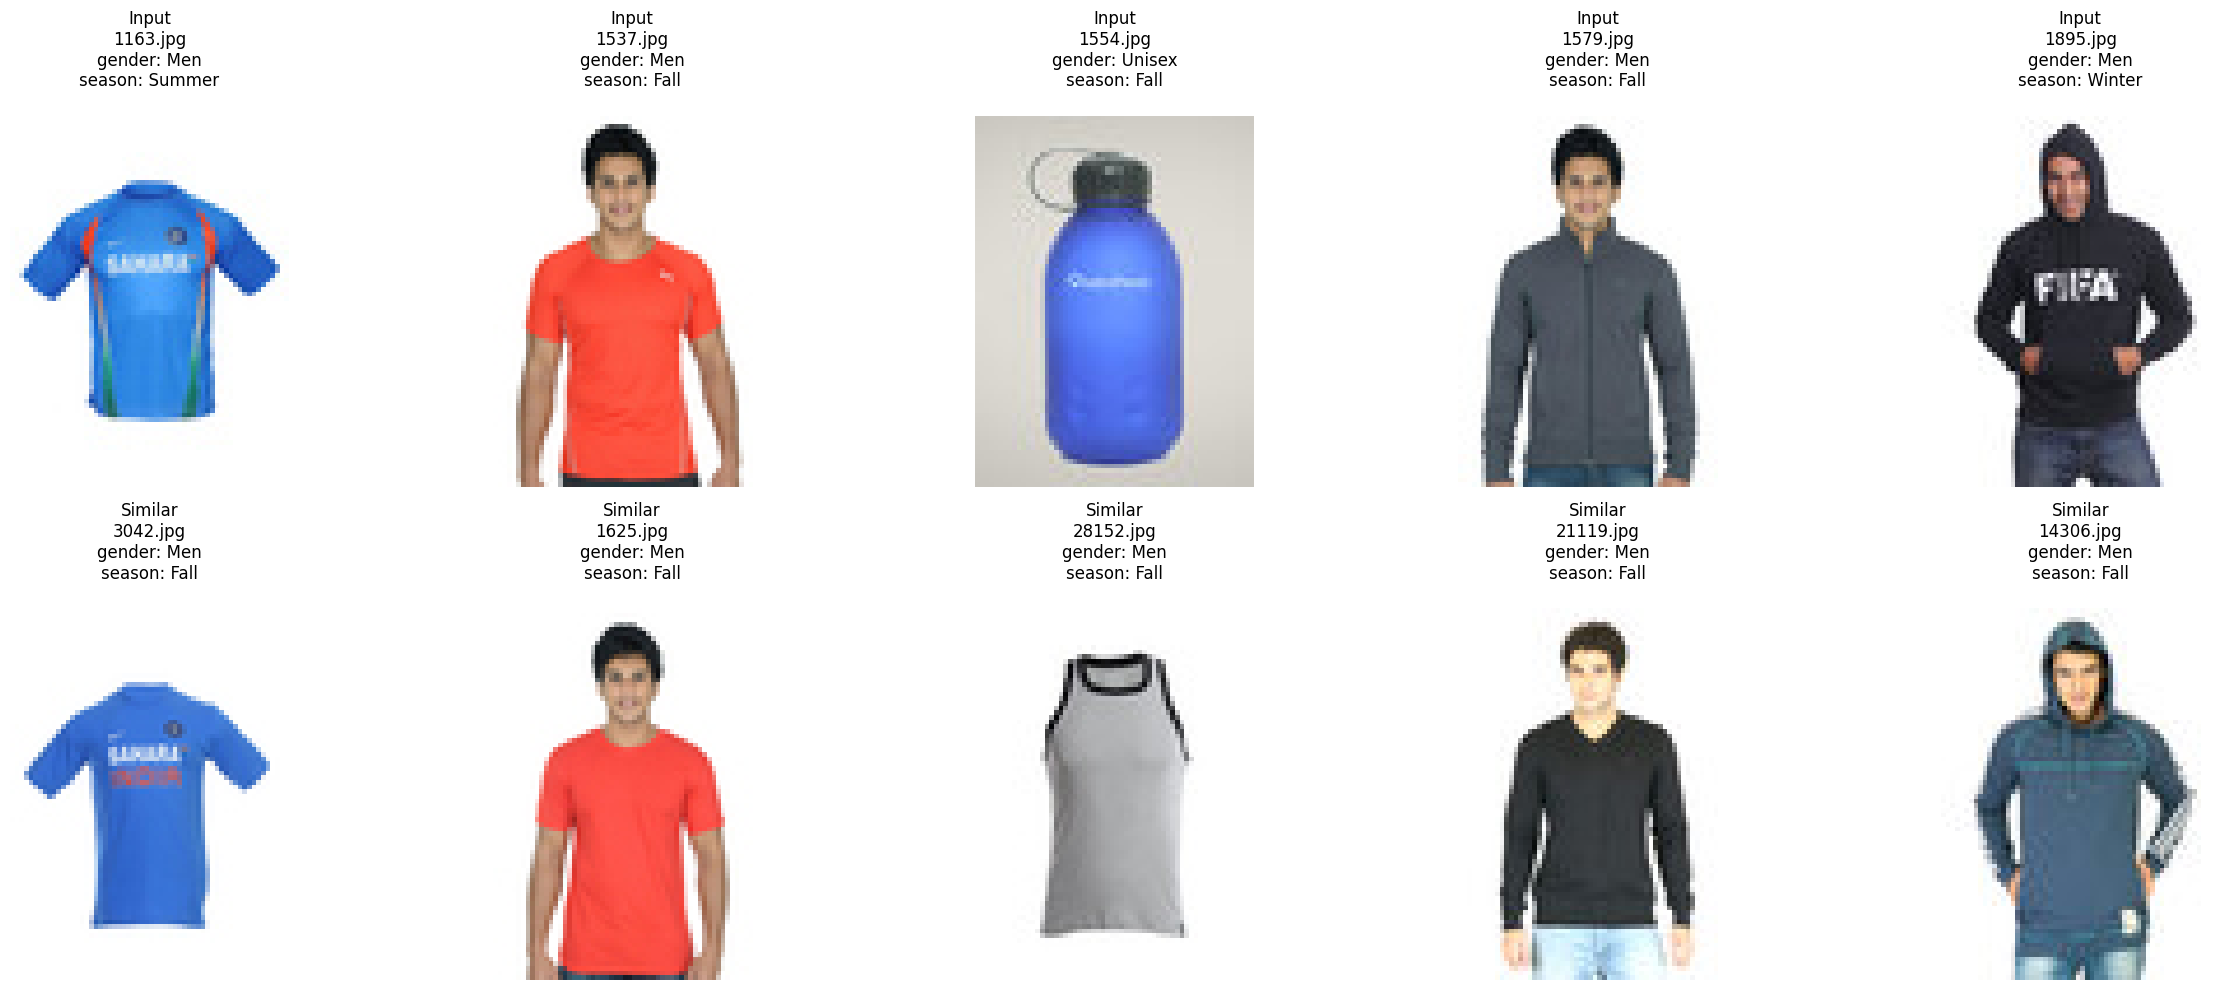

In [2]:
if os.path.exists(input_image_folder) and os.path.isdir(input_image_folder):
    input_image_paths = [os.path.join(input_image_folder, file) 
                         for file in os.listdir(input_image_folder) 
                         if file.endswith(('.jpg', '.png', '.jpeg'))]
    
    if not input_image_paths:
        print("Aucune image trouvée dans le dossier.")
    else:
        # Initialisation des caractéristiques des images similaires
        n_inputs = len(input_image_paths)
        similar_images = []

        # Extraire les caractéristiques et trouver les similaires
        for img_path in input_image_paths:
            try:
                feature = extract_features_from_images(img_path, model)
                distances, indices = neighbors.kneighbors([feature])
                
                # Sélectionner la première image similaire qui correspond aux préférences
                for idx in indices[0]:
                    similar_file_id = get_id_from_filename(filenames[idx])
                    meta_row = metadata[metadata['id'].astype(str) == similar_file_id]

                    if not meta_row.empty:
                        row = meta_row.iloc[0]
                        matches_preferences = all(
                            row[key] == value 
                            for key, value in preferences.items() 
                            if key in row
                        )
                        
                        if matches_preferences:
                            input_id = get_id_from_filename(img_path)
                            if similar_file_id != input_id:
                                similar_images.append((filenames[idx], meta_row))
                                break
                else:
                    similar_images.append((None, None))  # Aucun similaire trouvé

            except Exception as e:
                print(f"Erreur lors du traitement de l'image {img_path}: {str(e)}")
                similar_images.append((None, None))

        # Création des sous-graphes pour l'affichage
        fig, axes = plt.subplots(2, n_inputs, figsize=(5*n_inputs, 10))

        # Afficher les images d'entrée dans la première ligne
        for i, img_path in enumerate(input_image_paths):
            try:
                input_img = Image.open(img_path)
                axes[0, i].imshow(input_img)
                axes[0, i].axis('off')
                
                # Ajouter des métadonnées dans le titre
                input_id = get_id_from_filename(img_path)
                input_meta = metadata[metadata['id'].astype(str) == input_id]
                if not input_meta.empty:
                    title = f"Input\n{os.path.basename(img_path)}\n"
                    for key in preferences.keys():
                        title += f"{key}: {input_meta.iloc[0][key]}\n"
                    axes[0, i].set_title(title)
                else:
                    axes[0, i].set_title(f"Input\n{os.path.basename(img_path)}")
            except Exception as e:
                print(f"Erreur lors de l'affichage de l'image d'entrée {img_path}: {str(e)}")
                axes[0, i].axis('off')

        # Afficher les images similaires dans la deuxième ligne
        for i, (similar_path, similar_meta) in enumerate(similar_images):
            if similar_path:
                try:
                    similar_img = Image.open(similar_path)
                    axes[1, i].imshow(similar_img)
                    axes[1, i].axis('off')
                    
                    # Créer le titre détaillé
                    title = f"Similar\n{os.path.basename(similar_path)}\n"
                    for key in preferences.keys():
                        title += f"{key}: {similar_meta.iloc[0][key]}\n"
                    axes[1, i].set_title(title)
                except Exception as e:
                    print(f"Erreur lors de l'affichage de l'image similaire {similar_path}: {str(e)}")
                    axes[1, i].axis('off')
            else:
                axes[1, i].axis('off')  # Pas de similaire trouvé

        plt.tight_layout()
        plt.show()
else:
    print("Le dossier spécifié n'existe pas ou n'est pas valide.")
